In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from collections import Counter
import ast # used for converting string lists to lists with string elements

## import Sofies data

In [2]:
# Load cleaned datasets
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv('data_cleaned/character_cleaned.csv')

for i in [movie_metadata, character_metadata]:
    i.columns = i.columns.str.replace(' ', '_')
    i.fillna(0, inplace=True)

C:\Users\kavus\AppData\Local\Temp\ipykernel_6160\3977295388.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')


In [3]:
print("MOVIE DATA COLUMNS:\n",movie_metadata.columns,"\n\n","CHARACTER DATA COLUMNS:\n",character_metadata.columns)

MOVIE DATA COLUMNS:
 Index(['Unnamed:_0', 'Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_name',
       'Movie_release_date', 'Movie_runtime', 'Movie_languages',
       'Movie_countries', 'Movie_genres', 'TMDB_id', 'TMDB_original_language',
       'TMDB_original_title', 'TMDB_overview', 'TMDB_popularity',
       'TMDB_release_date', 'TMDB_title', 'TMDB_vote_average',
       'TMDB_vote_count', 'TMDB_runtime', 'TMDB_budget', 'TMDB_IMDB_id',
       'TMDB_genres', 'Movie_box_office_revenue', 'Movie_release_year',
       'log_Movie_box_office_revenue', 'log_Movie_release_year'],
      dtype='object') 

 CHARACTER DATA COLUMNS:
 Index(['Unnamed:_0', 'Wikipedia_Movie_ID', 'Freebase_Movie_ID',
       'Movie_release_date', 'Character_name', 'Actor_DOB', 'Actor_gender',
       'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_age_at_movie_release', 'Freebase_character_map',
       'Freebase_character_ID', 'Freebase_actor_ID', 'Movie_release_year',
       'Actor_birth_year', 'log_M

## Kavus wrangling and regression

In [4]:
# # Select only numeric columns
# numeric_columns = movie_metadata.select_dtypes(include=['number']).columns

# # Calculate the number of rows and columns dynamically
# num_cols = 3
# num_rows = (len(numeric_columns) + num_cols - 1) // num_cols -1


# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))
# # Plot histograms for each numeric column
# for i, col in enumerate(numeric_columns[1:]):
#     row, col_index = divmod(i, num_cols)
#     movie_metadata[col].hist(ax=axes[row, col_index], bins=50)
#     axes[row, col_index].set_title(col)

# plt.tight_layout()
# plt.show()

In [5]:
print(character_metadata.shape, movie_metadata.shape)

(450669, 17) (81741, 26)


In [6]:
# Investigate corrupted data

threshold = 0  # Check proportion of 0 values

for col in ["log_Movie_box_office_revenue", "TMDB_vote_average"]:
    # Count the number of elements under the threshold
    below_threshold_count = len(movie_metadata[movie_metadata[col] == threshold])

    # Calculate the total number of elements in the column
    total_elements = len(movie_metadata[col])

    # Calculate the proportion
    proportion_below_threshold = below_threshold_count / total_elements

    print(f"Elements equal to 0 in column {col}: number = {below_threshold_count} which is {proportion_below_threshold:.2%}")

Elements equal to 0 in column log_Movie_box_office_revenue: number = 71728 which is 87.75%
Elements equal to 0 in column TMDB_vote_average: number = 25257 which is 30.90%


In [7]:
movie_metadata_filtered = movie_metadata[movie_metadata["Movie_box_office_revenue"] > 0]
movie_metadata_filtered["Movie_runtime"].fillna(movie_metadata_filtered["TMDB_runtime"], inplace=True)
movie_metadata_filtered.shape

C:\Users\kavus\AppData\Local\Temp\ipykernel_6160\4150729280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_metadata_filtered["Movie_runtime"].fillna(movie_metadata_filtered["TMDB_runtime"], inplace=True)


(10018, 26)

In [8]:
# check for filtered data
for col in ["log_Movie_box_office_revenue", "TMDB_vote_average"]:
    below_threshold_count = len(movie_metadata_filtered[movie_metadata_filtered[col] == threshold])
    total_elements = len(movie_metadata_filtered[col])
    proportion_below_threshold = below_threshold_count / total_elements

    print(f"Elements equal to 0 in column {col}: number = {below_threshold_count} which is {proportion_below_threshold:.2%}")

Elements equal to 0 in column log_Movie_box_office_revenue: number = 5 which is 0.05%
Elements equal to 0 in column TMDB_vote_average: number = 283 which is 2.82%


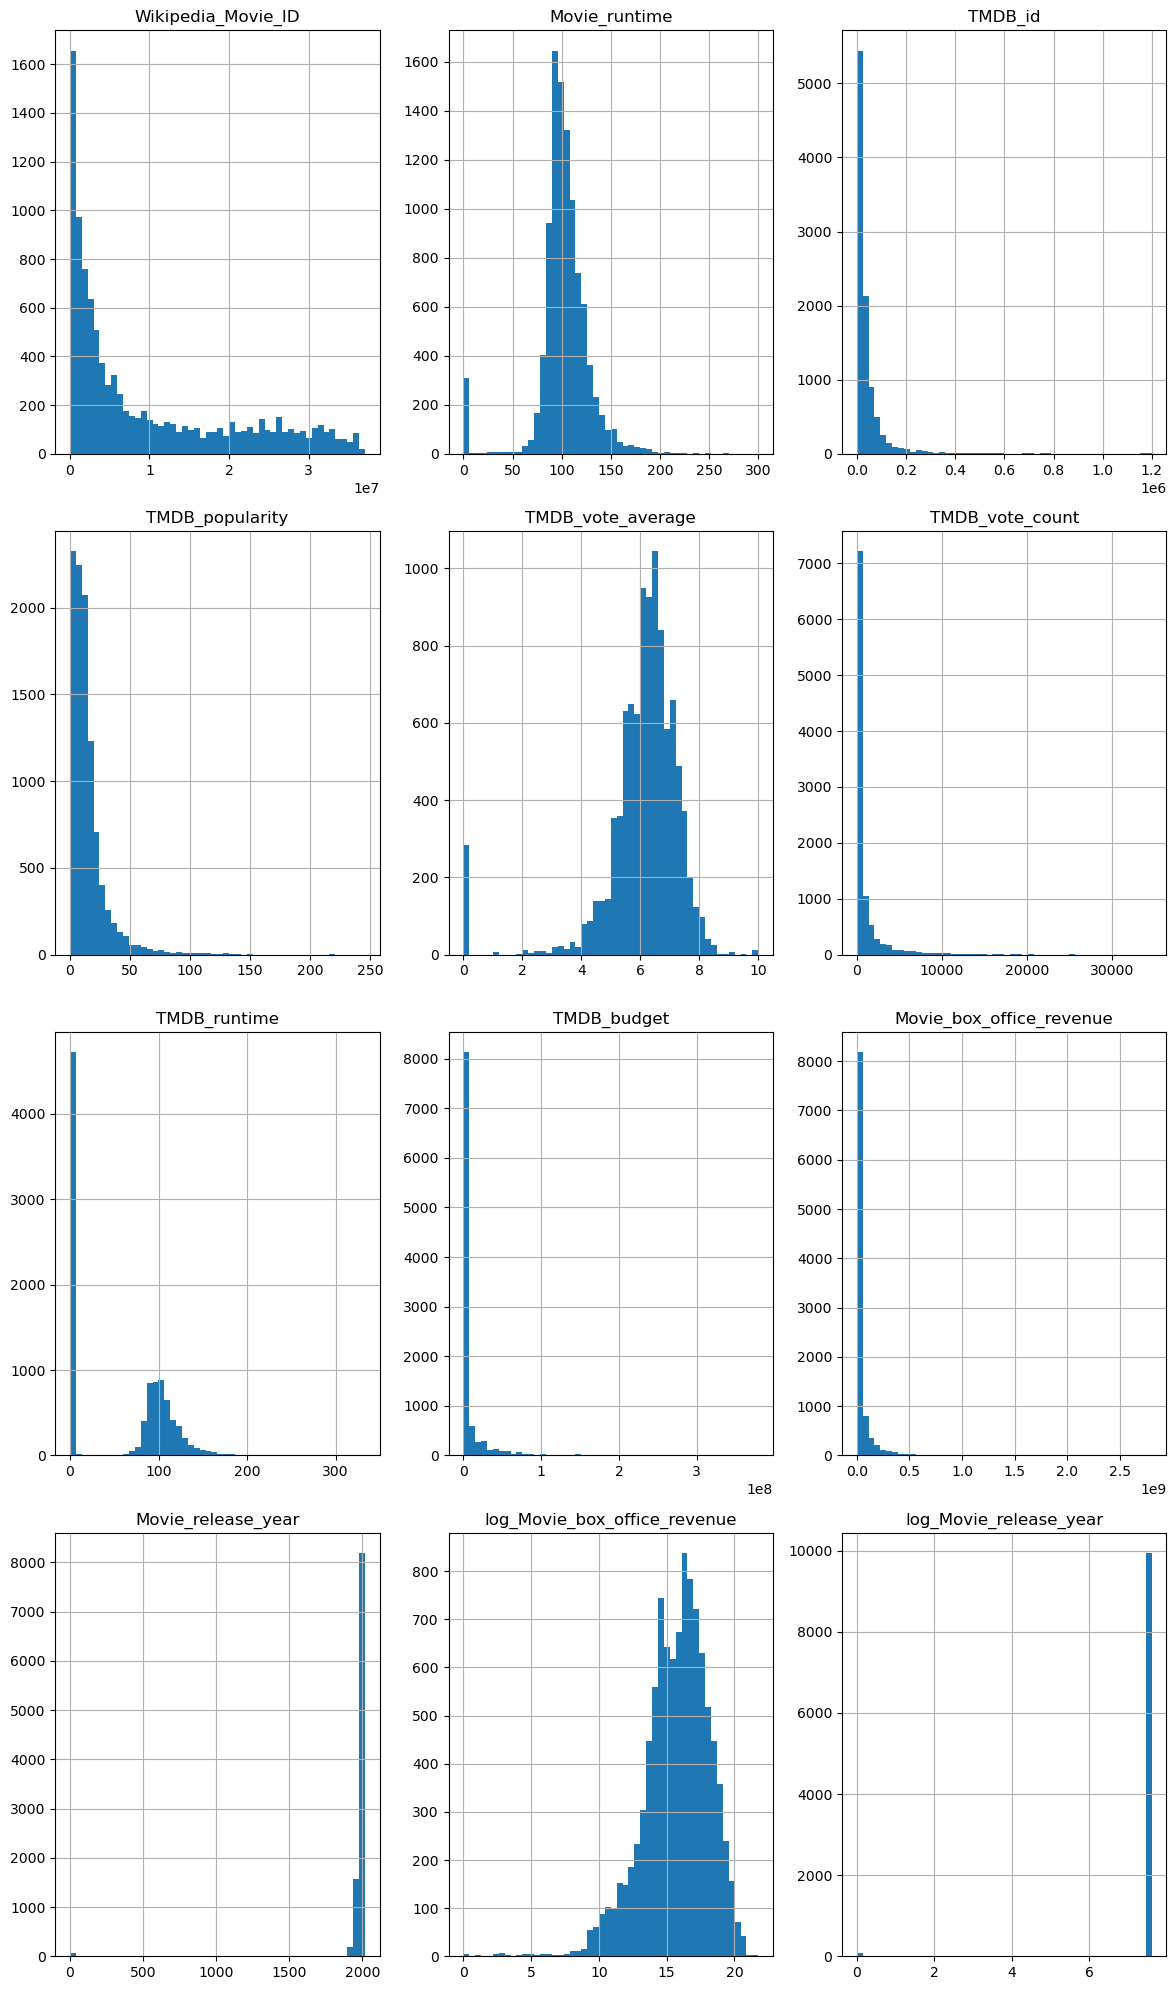

In [9]:
# Select only numeric columns
numeric_columns = movie_metadata_filtered.select_dtypes(include=['number']).columns

# Calculate the number of rows and columns dynamically
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols -1

# Increase figure size and adjust layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))

# Plot histograms for each numeric column
for i, col in enumerate(numeric_columns[1:]):
    row, col_index = divmod(i, num_cols)
    movie_metadata_filtered[col].hist(ax=axes[row, col_index], bins=50)
    axes[row, col_index].set_title(col)

plt.tight_layout()
plt.show()

In [10]:
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered["Movie_release_year"] > 1800]
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered["TMDB_vote_count"] > 3]
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered["Movie_runtime"] > 0]
movie_metadata_filtered.shape

(9220, 26)

### Regression

In [11]:
movie_reg_data = movie_metadata_filtered[['Movie_release_date', 'Movie_runtime', 'Movie_languages',
       'Movie_countries', 'Movie_genres', 'Movie_release_year',
       'log_Movie_box_office_revenue', 'TMDB_vote_average']]

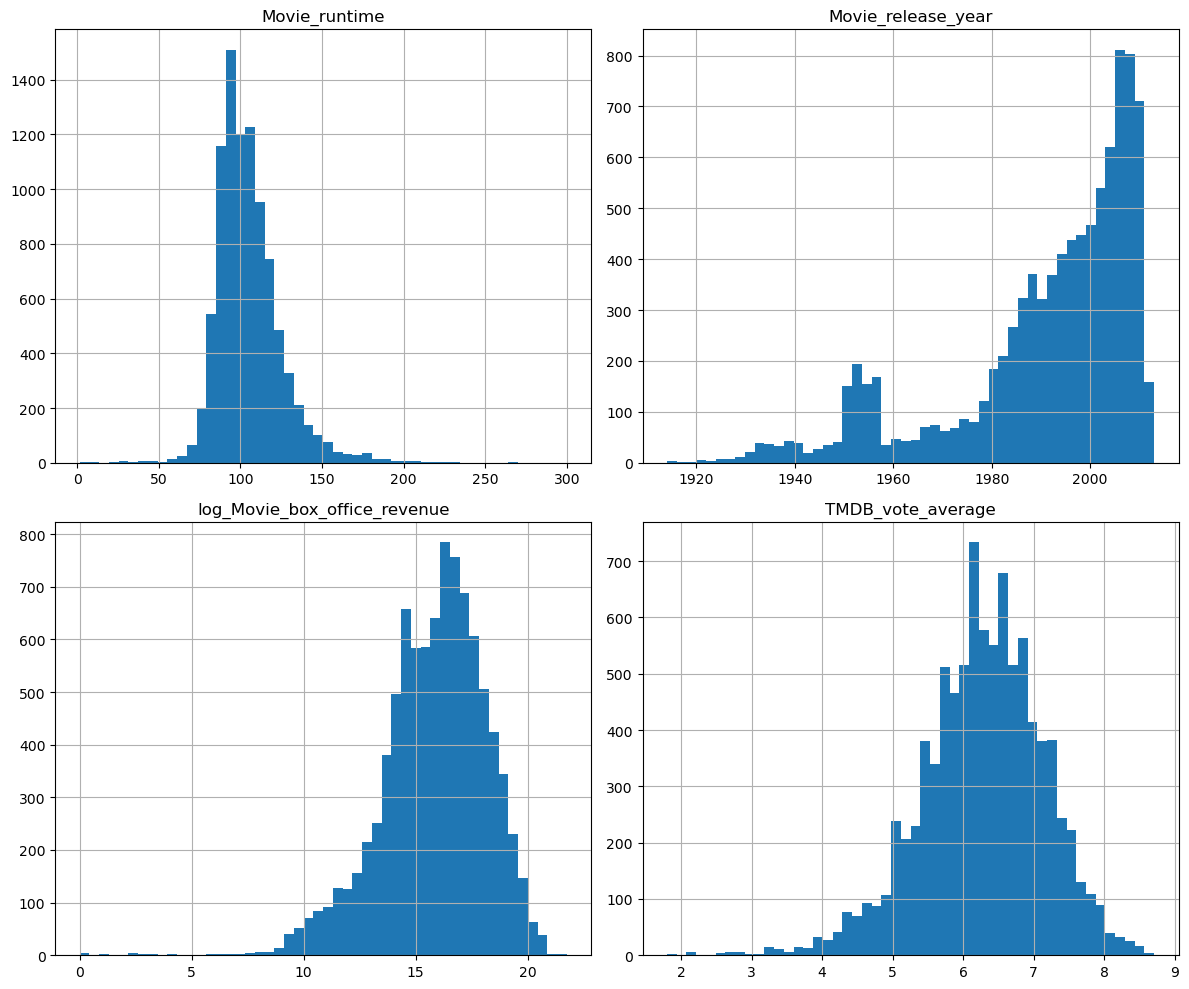

In [12]:
# Select numeric columns
numeric_columns = ['Movie_runtime', 'Movie_release_year', 'log_Movie_box_office_revenue', 'TMDB_vote_average']
num_cols = 2
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))

# Plot histograms for each numeric column
for i, col in enumerate(numeric_columns):
    row, col_index = divmod(i, num_cols)
    movie_reg_data[col].hist(ax=axes[row, col_index], bins=50)
    axes[row, col_index].set_title(col)

plt.tight_layout()
plt.show()

In [13]:
# Convert to list: ast.literal_eval("['Thriller', 'Horror']) will output the list ['Thriller', 'Horror']
categorical_columns = ['Movie_languages','Movie_countries', 'Movie_genres']

for column in categorical_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))
    movie_reg_data.loc[:, column] = movie_reg_data[column].apply(lambda x: ast.literal_eval(x))

print(movie_reg_data[categorical_columns])

['English'] 
 <class 'str'>
['United States of America'] 
 <class 'str'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'str'>
          Movie_languages                                    Movie_countries  \
0               [English]                         [United States of America]   
7               [English]                         [United States of America]   
13              [English]                                   [United Kingdom]   
17              [English]                         [United States of America]   
21              [English]                         [United States of America]   
...                   ...                                                ...   
81694           [English]  [Kingdom of Great Britain, Japan, England, Uni...   
81695           [English]                         [United States of America]   
81720           [English]                         [United States of America]   
81725  [Itali

In [14]:
# Check if converted to list
for column in categorical_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))

['English'] 
 <class 'list'>
['United States of America'] 
 <class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'list'>


In [15]:
categorical_columns = ['Movie_genres', 'Movie_languages', 'Movie_countries']

all_genres = {}
all_languages = {}
all_countries = {}

for col in categorical_columns:
    for list_element in movie_reg_data[col]:
        # Iterate over each element in the list
        for element in list_element:
            # Increment the count for the element in the respective dictionary
            if col == 'Movie_languages':
                all_languages[element] = all_languages.get(element, 0) + 1
            elif col == 'Movie_countries':
                all_countries[element] = all_countries.get(element, 0) + 1
            elif col == "Movie_genres":
                all_genres[element] = all_genres.get(element, 0) + 1

# Print the top N genres with the highest occurrences for each column
for occurrence_dict, column_name in zip([all_genres, all_languages, all_countries], categorical_columns):
    n = 10
    # Get the top N items with the highest occurrences (in descending order)
    top_n = sorted(occurrence_dict.items(), key=lambda x: x[1], reverse=True)[:n]

    print(f"\n\nTop {n} {column_name} with the highest occurrences:")
    for i, count in top_n:
        print(f"{i}: {count} occurrences")



Top 10 Movie_genres with the highest occurrences:
Drama: 4787 occurrences
Comedy: 3462 occurrences
Thriller: 2189 occurrences
Romance Film: 2186 occurrences
Action: 1944 occurrences
Action/Adventure: 1512 occurrences
Crime Fiction: 1420 occurrences
Adventure: 1242 occurrences
Indie: 1204 occurrences
Romantic comedy: 962 occurrences


Top 10 Movie_languages with the highest occurrences:
English: 7998 occurrences
French: 625 occurrences
Spanish: 496 occurrences
German: 309 occurrences
Italian: 289 occurrences
Japanese: 273 occurrences
Korean: 231 occurrences
Russian: 205 occurrences
Standard Mandarin: 146 occurrences
Hindi: 105 occurrences


Top 10 Movie_countries with the highest occurrences:
United States of America: 7342 occurrences
United Kingdom: 1101 occurrences
France: 611 occurrences
Germany: 518 occurrences
Canada: 367 occurrences
South Korea: 255 occurrences
Japan: 251 occurrences
Italy: 213 occurrences
Australia: 199 occurrences
Spain: 153 occurrences


In [16]:
movie_reg_data.shape

(9220, 8)

In [17]:
formula_revenue = 'log_Movie_box_office_revenue ~ Movie_runtime + Movie_release_year'
formula_rating = 'TMDB_vote_average ~ Movie_runtime + Movie_release_year'

# top n occurring elements in categorical columns
n = 10
print(movie_reg_data.shape)
for col in categorical_columns:
    # Flatten the lists, handling NaN values
    flattened_values = [item for sublist in movie_reg_data[col].apply(lambda x: x if isinstance(x, list) else []).dropna() for item in sublist]

    # Count occurrences of each element
    element_counts = pd.Series(flattened_values).value_counts()

    # Select the top 10 most occurring elements
    top_elements = element_counts.head(n).index.tolist()

    # Create dummy variables only for the top 10 elements
    dummy_variables = pd.get_dummies(pd.Series(flattened_values).apply(lambda x: x if x in top_elements else 'Other'))

    # Rename the dummy columns to avoid conflicts
    dummy_variables.columns = dummy_variables.columns.str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')
    dummy_variables.columns = [f"{col}_{element}" for element in dummy_variables.columns]
    
    # Reset index before concatenation
    movie_reg_data = movie_reg_data.reset_index(drop=True)
    
    # Add dummy variables to the formula
    formula_revenue += ' + ' + ' + '.join(dummy_variables.columns)
    formula_rating += ' + ' + ' + '.join(dummy_variables.columns)
    
    # Merge the dummy variables with the original DataFrame
    movie_reg_data = pd.merge(movie_reg_data, dummy_variables, left_index=True, right_index=True)

print(formula_revenue,
     "\n\n", formula_rating, dummy_variables.shape, movie_reg_data.shape)

(9220, 8)
log_Movie_box_office_revenue ~ Movie_runtime + Movie_release_year + Movie_genres_Action + Movie_genres_Action_Adventure + Movie_genres_Adventure + Movie_genres_Comedy + Movie_genres_Crime_Fiction + Movie_genres_Drama + Movie_genres_Indie + Movie_genres_Other + Movie_genres_Romance_Film + Movie_genres_Romantic_comedy + Movie_genres_Thriller + Movie_languages_English + Movie_languages_French + Movie_languages_German + Movie_languages_Hindi + Movie_languages_Italian + Movie_languages_Japanese + Movie_languages_Korean + Movie_languages_Other + Movie_languages_Russian + Movie_languages_Spanish + Movie_languages_Standard_Mandarin + Movie_countries_Australia + Movie_countries_Canada + Movie_countries_France + Movie_countries_Germany + Movie_countries_Italy + Movie_countries_Japan + Movie_countries_Other + Movie_countries_South_Korea + Movie_countries_Spain + Movie_countries_United_Kingdom + Movie_countries_United_States_of_America 

 TMDB_vote_average ~ Movie_runtime + Movie_release

In [18]:
print(movie_reg_data.shape, movie_metadata_filtered.shape, movie_metadata.shape)

(9220, 41) (9220, 26) (81741, 26)


In [19]:
# Setup models
model_revenue = smf.ols(formula=formula_revenue, data=movie_reg_data)
model_rating = smf.ols(formula=formula_rating, data=movie_reg_data)

In [20]:
np.random.seed(2)

# Fit the model
res_revenue = model_revenue.fit()
res_rating = model_rating.fit()

print(res_revenue.summary(),
      res_rating.summary())

                                 OLS Regression Results                                 
Dep. Variable:     log_Movie_box_office_revenue   R-squared:                       0.084
Model:                                      OLS   Adj. R-squared:                  0.081
Method:                           Least Squares   F-statistic:                     26.45
Date:                          Wed, 13 Dec 2023   Prob (F-statistic):          8.33e-150
Time:                                  17:29:19   Log-Likelihood:                -20588.
No. Observations:                          9220   AIC:                         4.124e+04
Df Residuals:                              9187   BIC:                         4.148e+04
Df Model:                                    32                                         
Covariance Type:                      nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      

C:\Users\kavus\AppData\Local\Temp\ipykernel_6160\3154726004.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


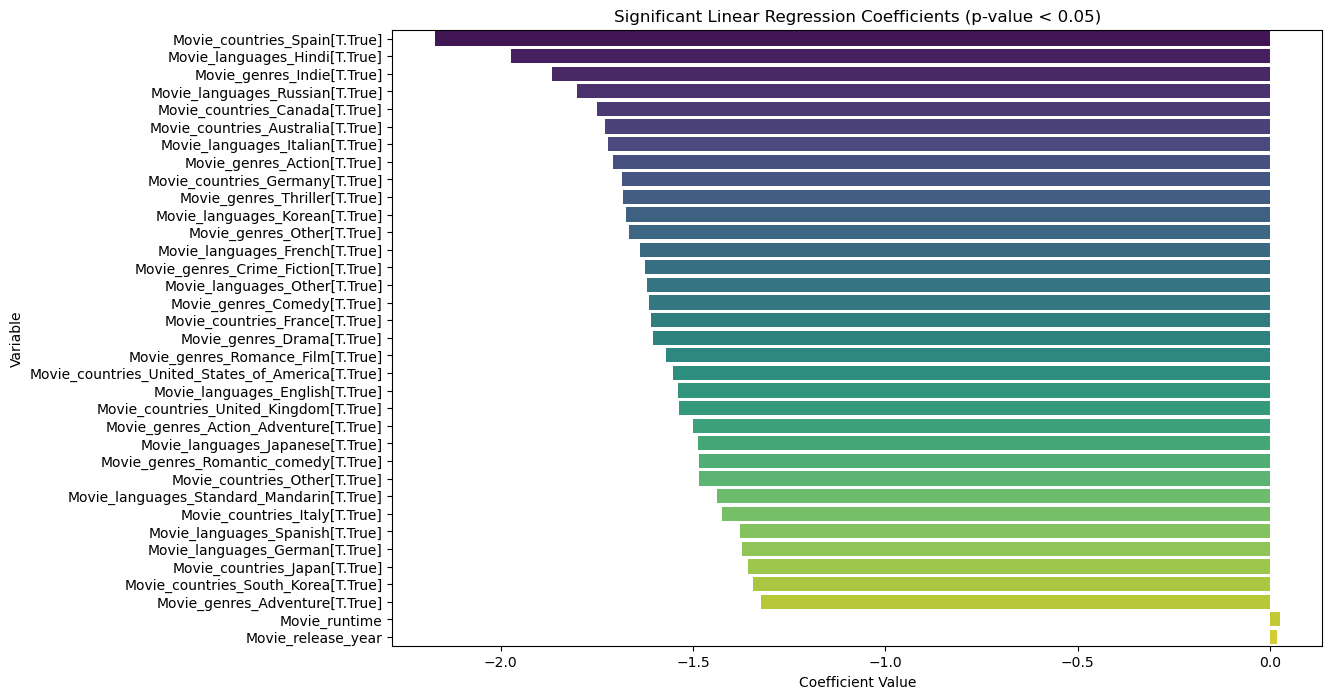

C:\Users\kavus\AppData\Local\Temp\ipykernel_6160\3154726004.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


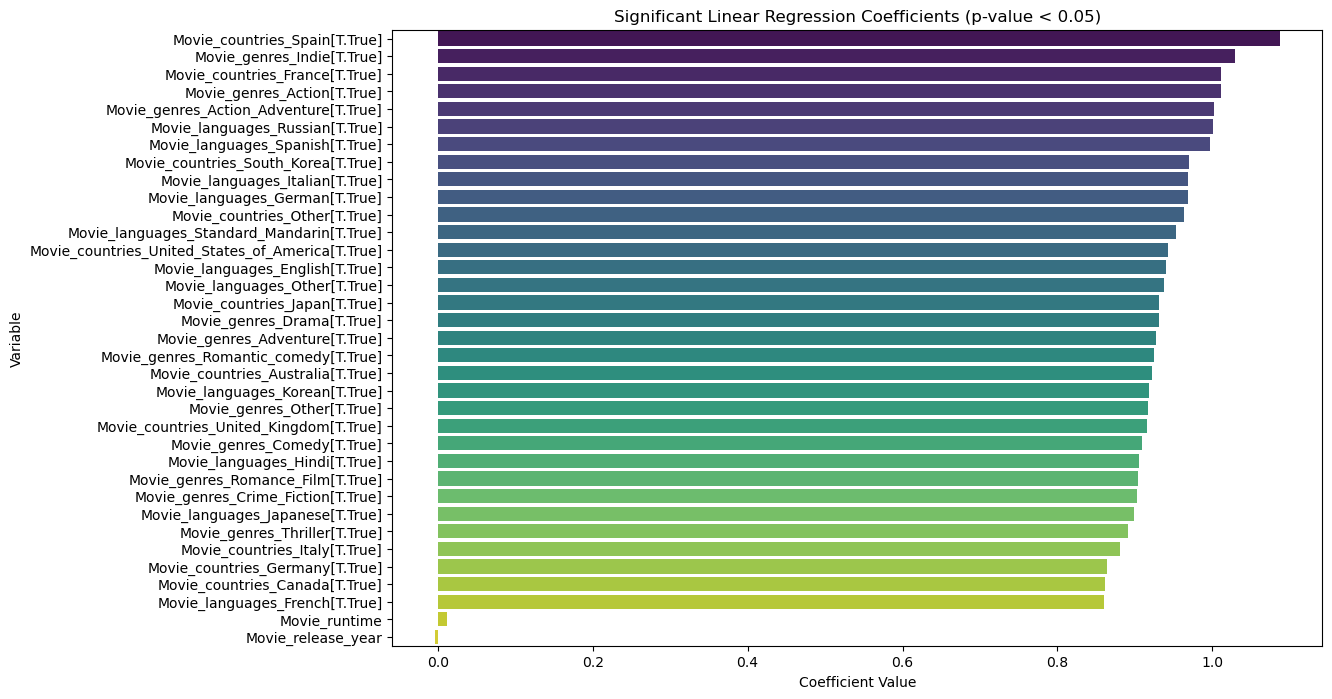

In [21]:
for res in [res_revenue, res_rating]:
# Extract
    coefficients = res.params
    p_values = res.pvalues
    coeff_names = coefficients.index

    # Create a DataFrame for better plotting
    coeff_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values, 'Name': coeff_names})

    # Exclude the intercept from the DataFrame
    coeff_df = coeff_df[coeff_df['Name'] != 'Intercept']

    # Filter coefficients with p-value < 0.05
    significant_coeff_df = coeff_df[coeff_df['P-Value'] < 0.05]

    # Sort coefficients by magnitude for better visualization
    significant_coeff_df = significant_coeff_df.reindex(significant_coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

    # Plot significant coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')
    plt.title('Significant Linear Regression Coefficients (p-value < 0.05)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variable')
    plt.show()

In [22]:
# Extract coefficients and p-values from the fitted models
coefficients_revenue = res_revenue.params
pvalues_revenue = res_revenue.pvalues

coefficients_rating = res_rating.params
pvalues_rating = res_rating.pvalues

# Create dictionaries with tuples (coefficient, p-value)
result_dict_revenue = {col: (coeff, pval) for col, coeff, pval in zip(coefficients_revenue.index, coefficients_revenue.values, pvalues_revenue.values)}
result_dict_rating = {col: (coeff, pval) for col, coeff, pval in zip(coefficients_rating.index, coefficients_rating.values, pvalues_rating.values)}

print("Results for log_Movie_box_office_revenue:")
print(result_dict_revenue)

print("\nResults for TMDB_vote_average:")
print(result_dict_rating)

Results for log_Movie_box_office_revenue:
{'Intercept': (-17.648018053766954, 2.932604279765252e-20), 'Movie_genres_Action[T.True]': (-1.7089874615327978, 2.5704317078357593e-16), 'Movie_genres_Action_Adventure[T.True]': (-1.5002444401803934, 3.911493407675043e-12), 'Movie_genres_Adventure[T.True]': (-1.3234495595591638, 3.3347636753943692e-09), 'Movie_genres_Comedy[T.True]': (-1.614093555838636, 1.0100897478360652e-16), 'Movie_genres_Crime_Fiction[T.True]': (-1.6245920743120958, 3.871085182376814e-14), 'Movie_genres_Drama[T.True]': (-1.6048002176201397, 1.427900359938683e-17), 'Movie_genres_Indie[T.True]': (-1.8671599324796935, 1.5567969245156892e-17), 'Movie_genres_Other[T.True]': (-1.6665864627464646, 1.131672220866751e-20), 'Movie_genres_Romance_Film[T.True]': (-1.5712739057637353, 7.929842752435429e-15), 'Movie_genres_Romantic_comedy[T.True]': (-1.4857539402106401, 1.9745165068852532e-10), 'Movie_genres_Thriller[T.True]': (-1.6810765035224007, 1.3303695326977308e-16), 'Movie_langu

In [23]:
movie_reg_data.shape

(9220, 41)

All the coefficients are significant on a 5% significance level. To asses how they contribute to the dependent variables Revenue and Rating, the coefficients will be interpreted in the two models.

## Results for log_Movie_box_office_revenue:

**Top Negative Predictors:**
1. Movie_genres_Action_Adventure: -1.89
2. Movie_genres_Crime_Fiction: -1.72
3. Movie_genres_Action: -1.70
4. Movie_genres_Adventure: -1.56
5. Movie_genres_Other: -1.56

Movies in Action, Adventure, and related genres tend to have a negative impact on the log of box office revenue.

**Top Positive Predictors:**
1. Movie_runtime: 0.027
2. Movie_release_year: 0.018
3. Movie_genres_Indie: 0.95
4. Movie_genres_Romance_Film: 0.84
5. Movie_genres_Drama: 0.70

An increase in runtime and release year is associated with an increase in the log of box office revenue. Also, Indie, Romance, and Drama genres have a positive impact.

## Results for TMDB_vote_average:

**Top Positive Predictors:**
1. Movie_genres_Other: 1.00
2. Movie_genres_Action: 0.95
3. Movie_genres_Romantic_comedy: 0.85
4. Movie_genres_Comedy: 0.98
5. Movie_genres_Romance_Film: 0.95

Movies in various genres, especially Other, Action, Romantic comedy, Comedy, and Romance, tend to have higher average vote ratings.

**Top Negative Predictor:**
- Movie_release_year: -0.004

More recent movies have slightly lower vote averages on TMDB.

## Similarities and Differences:

**Similarities:**
- Both models include similar genres as significant predictors, such as Action, Adventure, Comedy, and Drama.
- Movie_runtime is a common positive predictor in both models, influencing box office revenue positively and vote average negatively.

**Differences:**
- The impact of genres on revenue is negative, while on vote average, it can be positive (e.g., Romantic comedy, Indie, etc.).
- Movie_release_year has a positive impact on revenue but a negative impact on vote average.

In summary, genres, runtime, and release year play crucial roles in predicting box office revenue and vote average, and their impact can differ between the two outcomes.